In [1]:
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
import numpy as np

from qutip import * 
import os

# Matplotlib Einstellungen gemäß den LaTeX-Caption-Formatierungen
plt.rcParams.update({
#    'text.usetex': True,              # Enable LaTeX for text rendering
#    'font.family': 'serif',           # Use a serif font family
#    'font.serif': 'Palatino',         # Set Palatino as the serif font
#    'text.latex.preamble': r'\usepackage{amsmath}',
#    'font.size': 20,                   # Font size for general text
#    'axes.titlesize': 20,              # Font size for axis titles
#    'axes.labelsize': 20,              # Font size for axis labels
#    'xtick.labelsize': 20,             # Font size for x-axis tick labels
#    'ytick.labelsize': 20,             # Font size for y-axis tick labels
#    'legend.fontsize': 20,             # Font size for legends
#    'figure.figsize': [8, 6],          # Size of the plot (width x height)
#    'figure.autolayout': True,         # Automatic layout adjustment
#    'savefig.format': 'svg',           # Default format for saving figures
#    'figure.facecolor': 'none',        # Make the figure face color transparent
#    'axes.facecolor': 'none',          # Make the axes face color transparent
#    'savefig.transparent': True        # Save figures with transparent background
})
output_dir = os.getcwd()  # Gets the current working directory
os.makedirs(output_dir, exist_ok=True)

# allows for interactive plots
#%matplotlib notebook

$$
H = H_0 + H_I
$$

$$
H_0 = \hbar \omega_a \sum_{i=1}^{N_{\text{atoms}}} \sigma_+^{(i)} \sigma_-^{(i)} + \hbar \sum_{i,j=1}^{N_\text{{atoms}}} J_{ij} \sigma_+^{(i)} \sigma_-^{(j)} \quad \text{,} \quad J_{ij} = \frac{\alpha}{|r_i - r_j|^3}
$$

$$
H_I = \hbar D \cdot E(t)
\quad \text{,} \quad D = \mu \sum_{i=1}^{N_{\text{atoms}}} \sigma_+^{(i)} + \sigma_-^{(i)}
\quad \text{,} \quad E(t_i) \propto \Omega_{coupling} \cos(\pi (t - t_i)) \delta(t_i)
$$

### Decay operators single case
$$
C_{\text{decay}}^{(i)} = \sqrt{\gamma_0} \sigma_-^{(i)} \quad
C_{\text{dephase}}^{(i)} = \sqrt{\gamma_\phi} \sigma_z^{(i)}
$$

In [2]:
#
# Set the system parameters
#
# ENERGY LANDSCAPE, c = 1, hbar = 1
fixed_lam = 1. #
alpha     = 1. # coupling strength of the dipoles       Fine structure const?

omega_a   = 2 * np.pi / fixed_lam   # energysplitting of the atom, when ground state is set to 0
mu        = 1 * omega_a             # Dipole matrix element of each atom
omega_R   = 1 * omega_a             # Rabi freq coupling to laser field  for first 2 lasers  -> E_field_0 dot dot Dip_op, parallel

# LINBLAD OPS
gamma_0   = .1 # decay rate of the atoms
gamma_phi = .1 # dephasing rate of the atoms

# TOPOLOGY
n_chains = 1 # number of chains
n_rings  = 1 # number of rings
N_atoms  = n_chains * n_rings  # number of atoms

distance = 1. # * fixed_lam # defining topology

# TIME EVOLUTION
last_pulse = 6 # * gamma_0
last_det_t = 1 * last_pulse # last time when the system is measured -> t elem 0...last_det_t - T
time_steps = 100
tau_steps = time_steps
T_steps = time_steps // 1
approx_T_vals = np.linspace(0, last_det_t, T_steps)  # approximate T values

times_t = np.linspace(0, last_det_t, time_steps) # list of times_t
T_indices = np.array([np.abs(times_t - x).argmin() for x in approx_T_vals])

taus = np.linspace(0, last_det_t, time_steps)  # list of times_t for tau
Ts = times_t[T_indices]

mean_pos = [0, 0, 0]  # Mean position (can be any point in 3D space)
sigma_pos = N_atoms / 10  # Standard deviation for position distribution
########################################               define the geometry                 #############################################
def chain_positions(distance, N_atoms):
    Pos = np.zeros((N_atoms, 3))
    for i in range(N_atoms):
        Pos[i, 2] = i * distance
    return Pos
def z_rotation(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle),  np.cos(angle), 0],
        [0,              0,            1]])
def ring_positions(distance, n_chains):
    Pos = np.zeros((n_chains, 3))
    dphi = 2 * np.pi / n_chains
    if n_chains == 1:
        radius = 0
    else:
        radius = distance / 2 / np.sin(np.pi / n_chains)
    helper = np.array([radius, 0, 0])
    for i in range(n_chains):
        rotation_matrix = z_rotation(dphi * i)
        Pos[i] = np.matmul(rotation_matrix, helper)
    return Pos
def cyl_positions(distance, N_atoms, n_chains):
    Pos = np.zeros((N_atoms, 3))
    Pos_chain = chain_positions(distance, N_atoms // n_chains)
    Pos_ring = ring_positions(distance, n_chains)
    for i in range(n_chains):
        Pos[i * (N_atoms // n_chains): (i + 1) * (N_atoms // n_chains)] = Pos_chain + Pos_ring[i]
    return Pos
##################                           help functions                                 ##################
def count_decimal_digits(number):
    # Convert the number to string
    str_number = str(number)

    # Split the string at the decimal point and count the digits after it
    if '.' in str_number:
        return len(str_number.split('.')[1])
    else:
        return 0  # No digits after decimal if it's an integer
tolerance = count_decimal_digits(times_t[1]) - 2
def truncate_number(number, decimals=0):
    factor = 10.0 ** decimals
    return int(number * factor) / factor
def heaviside(x):
    return 1 if x >= 0 else 0
def sample_positions(mean_pos, sigma_pos, N_atoms):
    positions = []
    while len(positions) < N_atoms:
        # Sample a new position for the atom
        new_position = np.random.normal(loc=mean_pos, scale=sigma_pos, size=3)
        # Check if the new position is unique (no duplicates)
        if not any(np.allclose(new_position, pos) for pos in positions):
            positions.append(new_position)
    return np.array(positions)
def sample_frequencies(E0, Delta, N_atoms):
    # Sample N_atoms frequencies from the Gaussian distribution
    frequencies = np.random.normal(loc=E0, scale=Delta/2, size=N_atoms)
    return frequencies
def plot_positive_color_map(x, y, data, T = np.inf, space="real", type="real", positive=False, safe=False, output_dir=None, fixed_lam=None, alpha=None, gamma_0=None, gamma_phi=None, n_rings=None, n_chains=None, distance=None):
    """
    Create a color plot of 2D functional data for positive x and y values only.

    Parameters:
        x (np.array): 1D array of x values.
        y (np.array): 1D array of y values.
        data (np.array): 2D array of data values aligned with x and y.
        T (float): Temperature parameter to include in plot title and file name.
        space (str): Either 'real' or 'freq' specifying the space of the data.
        type (str): Type of data ('real', 'imag', 'abs', or 'phase'). Used only if space="freq".
        positive (bool): Whether to use only positive values of x and y.
        safe (bool): If True, saves the plot to a file.

    Returns:
        None
    """
    # Convert x and y into 1D arrays if they're not
    x = np.array(x)
    y = np.array(y)

    if positive:
        # Filter for positive x and y values
        positive_x_indices = np.where(x > 0)[0]  # Indices where x > 0
        positive_y_indices = np.where(y > 0)[0]  # Indices where y > 0
        x = x[positive_x_indices]
        y = y[positive_y_indices]
        data = data[np.ix_(positive_y_indices, positive_x_indices)]

    if space == "real":
        colormap = "viridis"
        label = r"$E_{out} \propto P / E_0$"
        title = f"Real space 2D Spectrum (arb. units)"
        if T != np.inf:
            title += f" at T ={T:.2f}"
        x_title = r"$t_{det}$ (arb. units)"
        y_title = r"$\tau_{coh}$ (arb. units)"
    elif space == "freq":
        if type == "real":
            title = f"Freq space, Real 2D Spectrum (arb. units)"
            data = np.real(data)
        elif type == "imag":
            title = f"Freq space, Imag 2D Spectrum (arb. units)"
            data = np.imag(data)
        elif type == "abs":
            title = f"Freq space, Abs 2D Spectrum (arb. units)"
            data = np.abs(data)
        elif type == "phase":
            title = "Freq space, Phase 2D Spectrum (arb. units)"
            data = np.angle(data)
        else:
            raise ValueError("Invalid Type. Must be 'real', 'imag', 'abs', or 'phase'.")

        colormap = "plasma"
        label = r"$E_{out} \propto P / E_0$"
        if T != np.inf:
            title += f" at T ={T:.2f}"

        x_title = r"$\omega_{t_{det}}$ (arb. units)"
        y_title = r"$\omega_{\tau_{coh}}$ (arb. units)"

    else:
        raise ValueError("Invalid space. Must be 'real' or 'freq'.")

    # Check and adjust the dimensions of x, y, and data
    if data.shape[1] != len(x):
        raise ValueError(f"Length of x ({len(x)}) must match the number of columns in data ({data.shape[1]}).")
    if data.shape[0] != len(y):
        raise ValueError(f"Length of y ({len(y)}) must match the number of rows in data ({data.shape[0]}).")

    # Add 1 to the dimensions of x and y for correct pcolormesh behavior
    x = np.concatenate([x, [x[-1] + (x[-1] - x[-2])]])  # Add an extra value for the last x edge
    y = np.concatenate([y, [y[-1] + (y[-1] - y[-2])]])  # Add an extra value for the last y edge

    # Plot the color map
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(x, y, data / omega_R, shading="auto", cmap=colormap)
    plt.colorbar(label=label)
    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel(y_title)

    # Save the plot if safe is True
    if safe and output_dir is not None:
        file_name_combined = (
            f"Classical_lam{fixed_lam:.1f}_alpha={alpha:.2f}_g_0{gamma_0:.2f}_g_phi{gamma_phi:.2f}_"
            f"{n_rings}x{n_chains}_dist={distance:.2f}_positive={positive}_space={space}"
        )
        if space == "freq":
            file_name_combined += f"_type={type}"
        file_name_combined += ".svg"
        save_path_combined = os.path.join(output_dir, file_name_combined)
        plt.savefig(save_path_combined)

    plt.show()
def Hamilton0(distance, n_rings, n_chains):
    N_atoms = n_chains * n_rings
    Pos = cyl_positions(distance, N_atoms, n_chains) # sample_positions(mean_pos, sigma_pos, N_atoms)        #
    atom_frequencies = sample_frequencies(omega_a, 0.0125 * omega_a, N_atoms) # [omega_a] * N_atoms #
    H = 0
    for a in range(N_atoms):
        for b in range(N_atoms):
            op = sm_list[a].dag() * sm_list[b]
            if a != b:
                ra, rb = Pos[a, :], Pos[b, :]
                H += alpha / (np.linalg.norm(rb-ra))**3 * op
            else:
                H += atom_frequencies[a] *op # Diagonals except for |0><0|
    return H
def El_field(t, args):
    t0 = args['time']
    Delta = args['Delta']
    E = np.exp(1j*(args['omega'] * t + args['phi']))
    E += np.conjugate(E)
    # secure the field is 0 outside short range
    E *= np.cos(np.pi * (t - t0) / (2 * Delta))**2 * heaviside(t - (t0 - Delta)) * heaviside(t0 + Delta - t)

    return args['E0'] * E

# Define the ground & the excited states
# atomic dofs
atom_g = basis(N_atoms + 1, 0)
atom_es = [basis(N_atoms + 1, i) for i in range(1, N_atoms + 1)]
# initial state
psiini = atom_g # = |g>_atom

# combined dofs
sm_list = []    # lowering operators of atomic system
Dip_op = 0         # collective sigma_x operator for the system
for i in range(N_atoms):
    op = atom_g * atom_es[i].dag()
    sm_list.append(op)
    Dip_op += mu * op + mu * op.dag()
H0 = Hamilton0(distance, n_rings, n_chains)

# Jump / Expect Operators          # Define the decay collapse and dephasing operator for each spin
# Collapse operators
c_op2 = [np.sqrt(gamma_0) * op for op in sm_list]                         # Individual atom decays
c_op4 = [np.sqrt(gamma_phi) * commutator(op.dag(), op) for op in sm_list] # Individual atom dephasing
c_op_list = c_op2 + c_op4  # Combine all collapse operators
# Expectation operators for measuring populations across atomic ground and excited levels
e_op_list = [ket2dm(basis(N_atoms + 1, i)) for i in range(N_atoms + 1)]

#
# evolution with t
#
# create the time dependant evolution
Omegas = [omega_R, omega_R, omega_R/10] # Probe pulse is smaller
omegas = [omega_a, omega_a, omega_a]    # The laser is on resonant
Delta_ts = [last_pulse/1000, last_pulse/1000, last_pulse/1000] # narrow width of the pulses
HI = [-Dip_op, El_field] # interaction Hamiltonian with function-based time dependence
H = [H0, HI]
options = Options(store_states=True)


#
# PREPROCESSING
#
# Phase cycling
phases = [0]#[-1 * i * np.pi / 2 for i in range(4)]
times_t, Ts

/home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


(array([0.        , 0.06060606, 0.12121212, 0.18181818, 0.24242424,
        0.3030303 , 0.36363636, 0.42424242, 0.48484848, 0.54545455,
        0.60606061, 0.66666667, 0.72727273, 0.78787879, 0.84848485,
        0.90909091, 0.96969697, 1.03030303, 1.09090909, 1.15151515,
        1.21212121, 1.27272727, 1.33333333, 1.39393939, 1.45454545,
        1.51515152, 1.57575758, 1.63636364, 1.6969697 , 1.75757576,
        1.81818182, 1.87878788, 1.93939394, 2.        , 2.06060606,
        2.12121212, 2.18181818, 2.24242424, 2.3030303 , 2.36363636,
        2.42424242, 2.48484848, 2.54545455, 2.60606061, 2.66666667,
        2.72727273, 2.78787879, 2.84848485, 2.90909091, 2.96969697,
        3.03030303, 3.09090909, 3.15151515, 3.21212121, 3.27272727,
        3.33333333, 3.39393939, 3.45454545, 3.51515152, 3.57575758,
        3.63636364, 3.6969697 , 3.75757576, 3.81818182, 3.87878788,
        3.93939394, 4.        , 4.06060606, 4.12121212, 4.18181818,
        4.24242424, 4.3030303 , 4.36363636, 4.42

In [3]:
#
# CALCULATIONS
#

# (first laser pulse)
times_0 = np.linspace(0, last_pulse, time_steps) # list of times_t

# Iterate over the phi values
def compute_first_pulse(phi_1):
    # Set the arguments for this particular phi
    args_0 = {
        'phi': phi_1,
        'time': Delta_ts[0],
        'omega': omegas[0],
        'Delta': Delta_ts[0],
        'E0': Omegas[0]
    }

    # Solve the system using mesolve
    result_0 = mesolve(H, psiini, times_0, c_ops=c_op_list, e_ops=e_op_list, args=args_0, options=options)

    # Prepare the data dictionary for this particular phi value
    current_dict = {}
    for i in range(len(times_0)):
        if (2 * Delta_ts[0] <= times_0[i] <= last_pulse - 2 * (Delta_ts[1] + Delta_ts[2])):
            current_dict[i] = result_0.states[i]
    return current_dict
def compute_second_pulse(phi_2, res_1):
    data_dict_stage2_local = {}
    times_1_dict = {}  # To store times_1 for each combination

    for i, psiini_1 in res_1.items():
        times_1 = times_t[i:]

        args_1 = {
            'phi': phi_2,  # Use phi_2 for the second pulse
            'time': times_1[0] + Delta_ts[1],
            'omega': omegas[1],
            'Delta': Delta_ts[1],
            'E0': Omegas[1]
        }

        # Solve the system using mesolve for the second pulse
        result_1 = mesolve(H, psiini_1, times_1, c_ops=c_op_list, e_ops=e_op_list, args=args_1, options=options)

        current_dict = {}
        for j in range(len(times_1)):  # Save only the states that make sense
            if (times_t[i] + 2 * Delta_ts[1] <= times_1[j] <= last_pulse - 2 * Delta_ts[2]):
                current_dict[j] = result_1.states[j]

        if current_dict:  # Check if the dictionary is not empty
            data_dict_stage2_local[i] = current_dict
            times_1_dict[i] = times_1  # Store times_1 for later access

    return data_dict_stage2_local, times_1_dict
def compute_third_pulse(res_2):
    data_dict = {}
    for i, dic1 in res_2[0].items():
        times_1 = res_2[1][i]
        count = 0
        # Iterate over the T values (waiting times) and calculate the last laser pulse
        for j, psiini_2 in dic1.items():
            spacing = times_1[1] - times_1[0]  # Difference between consecutive elements
            additional_times = np.arange(times_1[j], last_det_t + spacing, spacing)
            times_2 = additional_times

            T_j = times_1[j] + Delta_ts[2] - times_1[0] - Delta_ts[1]  # waiting_time_j
            T_j = truncate_number(T_j, tolerance - 2)
            T_c = truncate_number(Ts[count], tolerance - 2)
            # if the delay T is smaller than the current pulse difference, take next one
            while T_c < T_j and count < len(Ts) - 1:
                count += 1
                T_c = truncate_number(Ts[count], tolerance - 2)

            # ONLY NOW MAKE THE LAST PULSE
            if np.isclose(T_j, T_c):
                # Define the parameters for the last laser pulse
                args_2 = {
                    'phi': 0,  # Last pulse has no phase kick
                    'time': times_2[0] + Delta_ts[2],  # Duration for the 2nd pulse
                    'omega': omegas[2],  # Omega for the 2nd pulse
                    'Delta': Delta_ts[2],  # Delta for the 2nd pulse
                    'E0': Omegas[2]  # E0 for the 2nd pulse
                }

                # Solve the system using mesolve for the last pulse
                result_2 = mesolve(H, psiini_2, times_2, c_ops=c_op_list, e_ops=e_op_list, args=args_2, options=options)

                # Iterate over the states in result_2 and store the ones that meet the condition
                for k in range(len(times_2)):
                    if (times_1[j] + 2 * Delta_ts[2] <= times_2[k] <= last_det_t):
                        tau_i = times_1[0] + Delta_ts[1] - Delta_ts[0]
                        t_k = times_2[k] - times_2[0] - Delta_ts[2]
                        tau_i = truncate_number(tau_i, tolerance - 2)
                        t_k = truncate_number(t_k, tolerance - 2)

                        if T_j not in data_dict:
                            data_dict[T_j] = {}
                        if tau_i not in data_dict[T_j]:
                            data_dict[T_j][tau_i] = {}

                        # Compute the polarization and store it in the dictionary
                        Polarization = expect(Dip_op, result_2.states[k])
                        data_dict[T_j][tau_i][t_k] = Polarization
    return data_dict
# TEST
#x = compute_first_pulse(0)
#y = compute_second_pulse(0, x)
#z = compute_third_pulse(y)
def process_phi_combination(phi_1, phi_2):
    # Wrapper function to process each combination of phi_1 and phi_2
    # Step 1: Compute the first pulse for phi_1
    first_pulse_data = compute_first_pulse(phi_1)

    # Step 2: Compute the second pulse with the result from the first pulse
    second_pulse_data = compute_second_pulse(phi_2, first_pulse_data)

    # Step 3: Compute the third pulse with the result from the second pulse
    third_pulse_data = compute_third_pulse(second_pulse_data)
    return third_pulse_data

In [ ]:
#
# CALCULATIONS ALTERNATIVE
#

## (first laser pulse)
#times_0 = np.linspace(0, last_pulse, time_steps) # list of times_t
## Iterate over the phi values
#def compute_pulse(times, psiini, phi, which_pulse = 0):
#    args = {
#        'phi': phi,  # Use phi_2 for the second pulse
#        'time': Delta_ts[which_pulse],
#        'omega': omegas[which_pulse],
#        'Delta': Delta_ts[which_pulse],
#        'E0': Omegas[which_pulse]
#    }
#
#    # Solve the system using mesolve
#    result = mesolve(H, psiini, times, c_ops=c_op_list, e_ops=e_op_list, args=args, options=options)
#
#    # Prepare the data dictionary for this particular phi value
#    current_dict = {}
#    for i in range(len(times)):
#        if which_pulse == 0:
#            cond = (times[0] + 2 * Delta_ts[0] <= times[i] <= last_pulse - 2 * (Delta_ts[1] + Delta_ts[2]))
#        elif which_pulse == 1:
#            cond = (times[0] + 2 * (Delta_ts[0] + Delta_ts[1]) <= times[i] <= last_pulse - 2 * Delta_ts[2])
#        elif which_pulse == 2:
#            cond = (times[0] + 2 * Delta_ts[2] <= times[i] <= last_det_t)
#
#        if cond:
#            current_dict[i] = result.states[i]
#    return current_dict
#def process_phi_combination(phi_1, phi_2):
    data_dict = {}
    # Step 1: Compute the first pulse for phi_1
    x = compute_pulse(times_0, psiini, phi_1, which_pulse=0)

    # Step 2: Iterate over results of the first pulse
    for i, psi1 in x.items():
        # Compute the second pulse for phi_2
        y = compute_pulse(times_0[i:], psi1, phi_2, which_pulse=1)
        count = 0

        # Step 3: Iterate over results of the second pulse
        for j, psi2 in y.items():
            # Calculate T_j (waiting time)
            T_j = times_0[j] + Delta_ts[2] - times_0[i] - Delta_ts[1]
            T_j = truncate_number(T_j, tolerance - 2)

            # Retrieve or calculate T_c
            T_c = truncate_number(Ts[count], tolerance - 2)
            while T_c < T_j and count < len(Ts) - 1:
                count += 1
                T_c = truncate_number(Ts[count], tolerance - 2)

            # Check if T_j is approximately equal to T_c
            if np.isclose(T_j, T_c):
                # Compute the third pulse for current T_j and T_c
                spacing = times_0[1] - times_0[0]  # Difference between consecutive elements
                additional_times = np.arange(times_0[j], last_det_t + spacing, spacing)
                times_2 = additional_times
                z = compute_pulse(times_2, psi2, 0, which_pulse=2)

                # Step 4: Iterate over results of the third pulse
                for k, psi3 in z.items():
                    # Calculate tau_i and t_k
                    tau_i = times_0[i] + Delta_ts[1] - Delta_ts[0]
                    t_k = times_2[k] - times_0[j] - Delta_ts[2]

                    tau_i = truncate_number(tau_i, tolerance - 2)
                    t_k = truncate_number(t_k, tolerance - 2)

                    # Initialize nested structure in data_dict
                    if T_j not in data_dict:
                        data_dict[T_j] = {}
                    if tau_i not in data_dict[T_j]:
                        data_dict[T_j][tau_i] = {}

                    # Calculate Polarization
                    Polarization = expect(Dip_op, psi3)

                    # Store the result in data_dict
                    data_dict[T_j][tau_i][t_k] = Polarization

In [4]:
# Initialize results dictionary
all_results = {}
# Parallelize the computation for all combinations of phi_1 and phi_2
max_workers = min(len(phases) ** 2, os.cpu_count())  # Limit workers based on available CPUs
with ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Track each future and corresponding (phi_1, phi_2)
    futures = {executor.submit(process_phi_combination, phi_1, phi_2): (phi_1, phi_2)
               for phi_1 in phases for phi_2 in phases}

    # Collect results as they complete
    for future in futures:
        phi_1, phi_2 = futures[future]  # Retrieve the associated (phi_1, phi_2)
        third_pulse_data = future.result()
        if third_pulse_data is not None:
            all_results[(phi_1, phi_2)] = third_pulse_data

#all_results[(0,0)] # now contains the results keyed by (phi_1, phi_2)

In [5]:
#print(len(list(all_results[(0,0)][0.9243697478991].keys())))
#print(len(list(all_results[(0,0)][0.9243697478991][0.1680672268907].keys())))

In [6]:
# Initialize the averaged_data_dict
averaged_data_dict = {}

# Collect all unique T_j values from all_results dictionary
unique_T_j = sorted({T_key for (phi_1, phi_2) in all_results for T_key in all_results[(phi_1, phi_2)]})

# Iterate over unique T_j values
for T_j in unique_T_j:
    averaged_data_dict[T_j] = {}

    # Collect all unique tau_i values for the current T_j
    unique_tau_i = {tau_key for (phi_1, phi_2) in all_results
                    if T_j in all_results[(phi_1, phi_2)]
                    for tau_key in all_results[(phi_1, phi_2)][T_j]}

    # Iterate over unique tau_i values
    for tau_i in unique_tau_i:
        averaged_data_dict[T_j][tau_i] = {}

        # Collect all unique t_k values for the current (T_j, tau_i)
        unique_t_k = {t_key for (phi_1, phi_2) in all_results
                      if T_j in all_results[(phi_1, phi_2)] and tau_i in all_results[(phi_1, phi_2)][T_j]
                      for t_key in all_results[(phi_1, phi_2)][T_j][tau_i]}

        # Iterate over unique t_k values
        for t_k in unique_t_k:
            # Calculate the sum of polarization values across all phase combinations
            polarization_sum = sum(
                all_results[(phi_1, phi_2)][T_j][tau_i].get(t_k, 0)
                for (phi_1, phi_2) in all_results
                if T_j in all_results[(phi_1, phi_2)] and tau_i in all_results[(phi_1, phi_2)][T_j]
            )

            # Count the number of valid entries for averaging
            valid_count = sum(
                1 for (phi_1, phi_2) in all_results
                if T_j in all_results[(phi_1, phi_2)]
                and tau_i in all_results[(phi_1, phi_2)][T_j]
                and t_k in all_results[(phi_1, phi_2)][T_j][tau_i]
            )

            # Store the averaged polarization value
            averaged_data_dict[T_j][tau_i][t_k] = polarization_sum / max(1, valid_count)

In [7]:
#
# Prepare PLOTTING
#
# Function to prepare data for a single T value
def prepare_data_for_T(selected_T_j):
    # Extract and sort keys
    tau_i_keys = np.array(sorted(averaged_data_dict[selected_T_j].keys()))
    t_k_keys = np.array(sorted(set(t_k for tau_i in tau_i_keys for t_k in averaged_data_dict[selected_T_j][tau_i].keys())))

    # Create 2D grid for polarization data
    data = np.ones((len(tau_i_keys), len(t_k_keys)))

    for i, tau_i in enumerate(tau_i_keys):
        for j, t_k in enumerate(t_k_keys):
            data[i, j] = averaged_data_dict[selected_T_j][tau_i].get(t_k, 0)

#    print(f"T: {selected_T_j}")
#    print(f"t_k_keys (len={len(t_k_keys)})")#: {t_k_keys}
#    print(f"tau_i_keys (len={len(tau_i_keys)})")#: {tau_i_keys}
#    print(f"data shape: {data.shape}")

    return {
        "ts": t_k_keys,  # Local ts specific to T
        "taus": tau_i_keys,  # Local taus specific to T
        "data": data,  # Local data
    }

97 109
96 107
95 106
94 105
93 105
92 104
91 102
90 101
89 99
88 99
86 97
86 96
85 94
84 95
83 93
82 92
81 92
80 91
79 89
78 88
77 85
76 84
75 83
74 82
73 80
71 77
71 76
70 75
69 73
68 73
67 72
66 71
28 68
37 67
64 69
63 68
62 67
61 66
60 65
59 64
58 62
57 61
56 57
55 56
54 55
53 53
52 52
51 51
50 50
49 49
48 48
47 47
46 46
45 45
44 44
43 43
42 42
41 41
40 40
39 39
38 38
37 37
36 36
35 35
34 34
33 33
32 32
31 31
30 30
29 29
28 28
27 27
26 26
25 25
24 24
23 23
22 22
21 21
20 20
19 19
18 18
17 17
16 16
15 15
14 14
13 13
12 12
11 11
10 10
9 9
8 8
7 7
6 6
5 5
4 4
3 3
Skipped T_j=5.7575757575757 due to insufficient data (taus=3, ts=3)
2 2
Skipped T_j=5.8181818181818 due to insufficient data (taus=2, ts=2)
1 1
Skipped T_j=5.8787878787878 due to insufficient data (taus=1, ts=1)


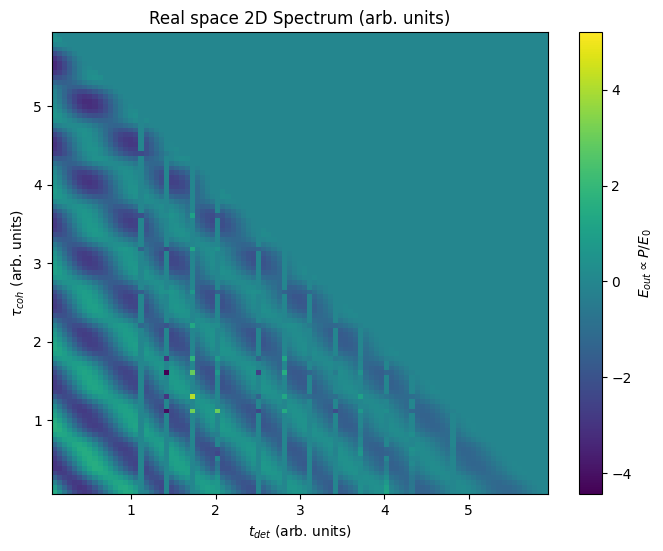

In [9]:
for idx, T_j in enumerate(unique_T_j):  # Use enumerate to count iterations
    data = prepare_data_for_T(T_j)

    if idx == 0:  # First iteration
        smallest_key = T_j
        global_ts = data["ts"]
#            print(len(data["ts"]), len(data["taus"]))
        global_taus = data["taus"]
        # Sum all data into global sum
        global_data_time = np.zeros((len(global_taus), len(global_ts)))
        global_data_freq = np.zeros((len(global_taus), len(global_ts)), dtype=np.complex64)
        global_t_freqs = (np.fft.fftfreq(len(global_ts), d=(global_ts[1] - global_ts[0])))  # Frequency axis for detection time
        global_tau_freqs = (np.fft.fftfreq(len(global_taus), d=(global_taus[1] - global_taus[0])))  # Frequency axis for excitation time

    taus = data["taus"]  # Local taus for the current T
    ts = data["ts"]  # Local ts for the current T

    print(len(taus), len(ts))

    if len(taus) < 4 or len(ts) < 4:
        print(f"Skipped T_j={T_j} due to insufficient data (taus={len(taus)}, ts={len(ts)})")
        continue

    data_time = data["data"]  # Aligned 2D data

    # Prepare to extend local data into global coordinates
    data_extended_time = np.zeros_like(global_data_time)

    # Map taus and ts to global indices
    global_tau_indices = {tau: idx for idx, tau in enumerate(global_taus)}
    global_t_indices = {t: idx for idx, t in enumerate(global_ts)}

    # Map taus and ts to global indices
    for i, tau in enumerate(taus):
        global_i = np.where(global_taus == tau)[0]  # Array of indices where condition is True
        if global_i.size > 0:  # Ensure we have valid matches
            global_i = global_i[0]
        else:
            continue  # Skip if no valid mapping

        for j, t in enumerate(ts):
            global_j = np.where(global_ts == t)[0]  # Array of indices where condition is True
            if global_j.size > 0:  # Ensure we have valid matches
                global_j = global_j[0]
            else:
                continue  # Skip if no valid mapping

            # Assign values if valid global indices exist
            data_extended_time[global_i, global_j] = data_time[i, j]
            global_data_time[global_i, global_j] += data_time[i, j]

    data_extended_freq = np.fft.fft2(data_extended_time)
#    plot_positive_color_map(ts, taus, data_time, T_j)
#    plot_positive_color_map(global_ts, global_taus, data_extended_time, T_j, safe = False)
#    plot_positive_color_map(global_t_freqs, global_tau_freqs, data_extended_freq, T_j, space = "freq", type = "real", positive = True, safe = False)
    global_data_freq += data_extended_freq

# Plot the aggregated results
plot_positive_color_map(global_ts, global_taus, global_data_time, safe=False)  # Global time-space data
#plot_positive_color_map(global_t_freqs, global_tau_freqs, global_data_freq, space="freq", type="abs", positive=True, safe=False)  # Global frequency-space data